In [1]:
import os


In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    ToolMessage,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langgraph.graph import END, StateGraph, START

In [4]:
def create_agent(llm, tools, system_message: str):
    """Create an Agent"""
    prompt = ChatPromptTemplate.from_messages([
        (
            "system",
            """You are a helpful AI assistant, collabrating with other assistants.
            Use the provided tools to progress towards answering the question.
            If you are unable to fully answer, that's OK, another assistant with different tools will help where you left off.
            Execute what you can to make progress.
            If you or any of the other assistants have the final answer or deliverable,
            prefix your response with FINAL ANSWER so the team knows to stop.
            You have access to the following tools: {tool_names}.\n{system_message},
            
            """
        ),
        MessagesPlaceholder(variable_name="messages")
    ])
    prompt=prompt.partial(system_message=system_message)
    prompt=prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    return prompt | llm.bind_tools(tools)


# Define Tools

In [5]:
from typing import Annotated
from langchain_community.tools.tavily_search import TavilySearchResults

tavily_tool = TavilySearchResults(max_resutls=5)

In [6]:
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

repl = PythonREPL()

@tool
def python_repl(code: Annotated[str, "The python code to execute to generate your chart."]):
    """
    Execute the given Python code in a REPL environment and return the result.
    
    Args:
        code (str): The Python code to execute.
    
    Returns:
        str: The result of the code execution or an error message.
    """
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n````\nStdout: {result}"
    return (result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER.")
    

# Create graph
도구들을 정의하고 보조 함수를 만들었으므로, 아래에서 개별 에이전트들을 생성하고 LangGraph를 사용하여 서로 소통하는 방법

## Define State
먼저 그래프의 상태를 정의함, 이는 단순히 메시지 목록과 가장 최근에 메시지를 보낸 발신자(sender)를 추적하는 키로 구성됨

In [7]:
import operator
from typing import Annotated, Sequence, TypedDict

from langchain.chat_models import ChatOllama

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str #지금 메시지가 어떤 AI Agent에서 넘어왔는지 확인함

# Define Agent Nodes

In [8]:
import functools
from langchain_core.messages import AIMessage
from langchain_experimental.llms.ollama_functions import OllamaFunctions
def agent_node(state, agent, name):
    result = agent.invoke(state)

    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    return {
        "messages": [result],
        # Since we have a strict workflow, we can
        # track the sender so we know who to pass to next.
        "sender": name
    }

llm = OllamaFunctions(
    model="llama3.1:latest",
    format="json"
)

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_384\1962677245.py:18: LangChainDeprecationWarning: The class `OllamaFunctions` was deprecated in LangChain 0.0.64 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import ChatOllama``.
  llm = OllamaFunctions(


In [9]:
research_agent = create_agent(
    llm,
    [tavily_tool],
    system_message="You should provide accurate data for use, "
        "and source code shouldn't be the final answer",
)
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

In [10]:
chart_agent = create_agent(
    llm,
    [python_repl],
    system_message="Run the python code to display the chart."
)
chart_node = functools.partial(agent_node, agent=chart_agent, name="char_generator")

# Define Tool Node

In [11]:
from langgraph.prebuilt import ToolNode

tools = [tavily_tool, python_repl]
tool_node = ToolNode(tools)

# Define Edge Logic

In [12]:
from typing import Literal

def router(state) -> Literal["call_tool", "__end__", "continue"]:
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        return "__end__"
    return "continue"


# Define the Graph

In [13]:
workflow = StateGraph(AgentState)

workflow.add_node("Researcher", research_node)
workflow.add_node("chart_generator", chart_node)
workflow.add_node("call_tool", tool_node)

workflow.add_conditional_edges(
    "Researcher",
    router,
    {"continue": "chart_generator", "call_tool": "call_tool", "__end__": END}
)
workflow.add_conditional_edges(
    "chart_generator",
    router,
    {"continue": "Researcher", "call_tool": "call_tool", "__end__": END}
)
workflow.add_conditional_edges(
    "call_tool",
    lambda x: x["sender"],
    {
        "Researcher":"Researcher", 
        "chart_generator": "chart_generator"
     }
)
workflow.add_edge(START, "Researcher")
graph = workflow.compile()

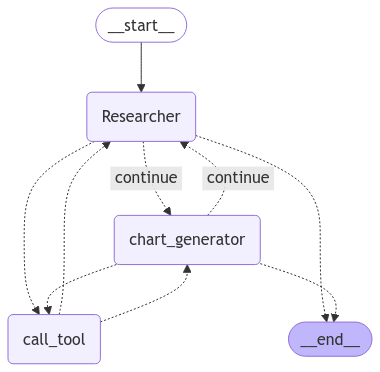

In [14]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    pass

# Invoke

In [ ]:
output = graph.invoke()

In [23]:
from langchain.schema import HumanMessage
# events = graph.stream(
#     {
#         "messages": [
#             HumanMessage(
#                 content="Fetch the USA's GDP over the past 3 years,"
#                 " then draw a line graph of it."
#                 " Once you code it up, finish."
#             )
#         ]
#     },
#     {"recursion_limit": 10}
# )

# for s in events:
#     print(s)
#     print("-----")
inputs = {}
for output in graph.stream(inputs):
    for key, value in output.item():
        print(f"Finished running: {key}:")

Failed to use model_dump to serialize <class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'pydantic._internal._model_construction.ModelMetaclass'>)
Failed to use model_dump to serialize <class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'pydantic._internal._model_construction.ModelMetaclass'>)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_384\1962677245.py:10: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)


{'Researcher': {'messages': [AIMessage(content='', additional_kwargs={}, response_metadata={}, name='Researcher', id='run-eff18665-418e-4e42-a566-6b03e602252c-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'USA GDP past 3 years'}, 'id': 'call_783d8d6484ad4ad4af2efcacfc8978aa', 'type': 'tool_call'}])], 'sender': 'Researcher'}}
-----


Failed to use model_dump to serialize <class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'pydantic._internal._model_construction.ModelMetaclass'>)
Failed to use model_dump to serialize <class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'pydantic._internal._model_construction.ModelMetaclass'>)


{'call_tool': {'messages': [ToolMessage(content='[{"url": "https://www.macrotrends.net/global-metrics/countries/USA/united-states/gdp-gross-domestic-product", "content": "| 2023 | $27,360.94B | $81,695 | 2.54% | | 2022 | $25,744.11B | $77,247 | 1.94% | | 2021 | $23,594.03B | $71,056 | 5.80% | | 2020 | $21,322.95B | $64,317 | -2.21% | | 2019 | $21,521.40B | $65,548 | 2.47% | | 2018 | $20,656.52B | $63,201 | 2.97% | | 2017 | $19,612.10B | $60,322 | 2.46% | | 2016 | $18,804.91B | $58,207 | 1.82% | | 2015 | $18,295.02B | $57,040 | 2.95% | | 2014 | $17,608.14B | $55,304 | 2.52% | | 2013 | $16,880.68B | $53,410 | 2.12% | | 2012 | $16,253.97B | $51,784 | 2.29% | | 2011 | $15,599.73B | $50,066 | 1.56% |"}, {"url": "https://www.multpl.com/us-gdp/table/by-year", "content": "US GDP by Year - Multpl S&P 500 PE Ratio US GDP by Year | Jun 30, 2024 | \u2002 29.02 trillion | | Dec 31, 2023 | \u2002 28.30 trillion | | Dec 31, 2022 | \u2002 26.73 trillion | | Dec 31, 2021 | \u2002 24.78 trillion | | Dec

ValueError: Received unsupported message type for Ollama.